# SVM Sentiment Classifier
Train an SVM on the preprocessed 388-d features (sentence embeddings + VADER).
Load from `data/processed/` artifacts saved by `preprocess.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import json
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Paths
PROCESSED_PATH = '/home/ram/sentiment_mlops/data/processed/'
MODEL_PATH = '/home/ram/sentiment_mlops/models/'
os.makedirs(MODEL_PATH, exist_ok=True)

# Load preprocessed data
X_train = np.load(os.path.join(PROCESSED_PATH, 'train_vectors.npy'))
y_train = np.load(os.path.join(PROCESSED_PATH, 'train_labels.npy'))
X_test = np.load(os.path.join(PROCESSED_PATH, 'test_vectors.npy'))
y_test = np.load(os.path.join(PROCESSED_PATH, 'test_labels.npy'))

with open(os.path.join(PROCESSED_PATH, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

label_map = metadata['label_map']
inv_label_map = {int(v): k for k, v in label_map.items()}

print(f'Training set: {X_train.shape}')
print(f'Test set:     {X_test.shape}')
print(f'Classes:      {inv_label_map}')
print(f'Feature type: {metadata["features"]}')

Training set: (27438, 388)
Test set:     (3682, 388)
Classes:      {0: 'positive', 1: 'neutral', 2: 'negative'}
Feature type: sentence_embeddings(384) + vader_scaled(4)


In [2]:
## Scale features (SVM is sensitive to feature magnitudes)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Scaled mean (should be ~0): {X_train_scaled.mean():.4f}')
print(f'Scaled std  (should be ~1): {X_train_scaled.std():.4f}')

Scaled mean (should be ~0): -0.0000
Scaled std  (should be ~1): 1.0000


In [3]:
## Train SVM with RBF kernel
# probability=True enables predict_proba (needed for deployment confidence scores)
print('Training SVM... (this may take a few minutes on 27k x 388 data)')

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    verbose=True
)

svm_model.fit(X_train_scaled, y_train)
print('\nTraining complete!')

Training SVM... (this may take a few minutes on 27k x 388 data)
[LibSVM].....*..*
optimization finished, #iter = 7833
obj = -2749.810009, rho = 3.088637
nSV = 5694, nBSV = 2742
Total nSV = 5694
.....*..*
optimization finished, #iter = 7800
obj = -2718.408508, rho = 3.204067
nSV = 5670, nBSV = 2710
Total nSV = 5670
.....*..*
optimization finished, #iter = 7934
obj = -2755.702733, rho = 3.108410
nSV = 5718, nBSV = 2744
Total nSV = 5718
.....*..*
optimization finished, #iter = 7917
obj = -2775.950888, rho = 3.177585
nSV = 5773, nBSV = 2756
Total nSV = 5773
.....*..*
optimization finished, #iter = 7785
obj = -2716.644901, rho = 3.110086
nSV = 5644, nBSV = 2714
Total nSV = 5644
.......*..*
optimization finished, #iter = 9407
obj = -3318.260031, rho = -3.060388
nSV = 6817, nBSV = 3334
...*..*
optimization finished, #iter = 5007
obj = -1333.229047, rho = 3.409630
nSV = 3350, nBSV = 1257
Total nSV = 3350
...*.*
optimization finished, #iter = 4980
obj = -1326.401353, rho = 3.335989
nSV = 3358, 

In [4]:
## Evaluate on test set
y_pred = svm_model.predict(X_test_scaled)

# Overall accuracy
acc = accuracy_score(y_test, y_pred)
print(f'\n=== Test Accuracy: {acc:.4f} ({acc*100:.1f}%) ===\n')

# Per-class report
target_names = [inv_label_map[i] for i in sorted(inv_label_map.keys())]
print(classification_report(y_test, y_pred, target_names=target_names))


=== Test Accuracy: 0.7966 (79.7%) ===

              precision    recall  f1-score   support

    positive       0.88      0.88      0.88      2286
     neutral       0.65      0.66      0.66       928
    negative       0.68      0.64      0.66       468

    accuracy                           0.80      3682
   macro avg       0.74      0.73      0.73      3682
weighted avg       0.80      0.80      0.80      3682



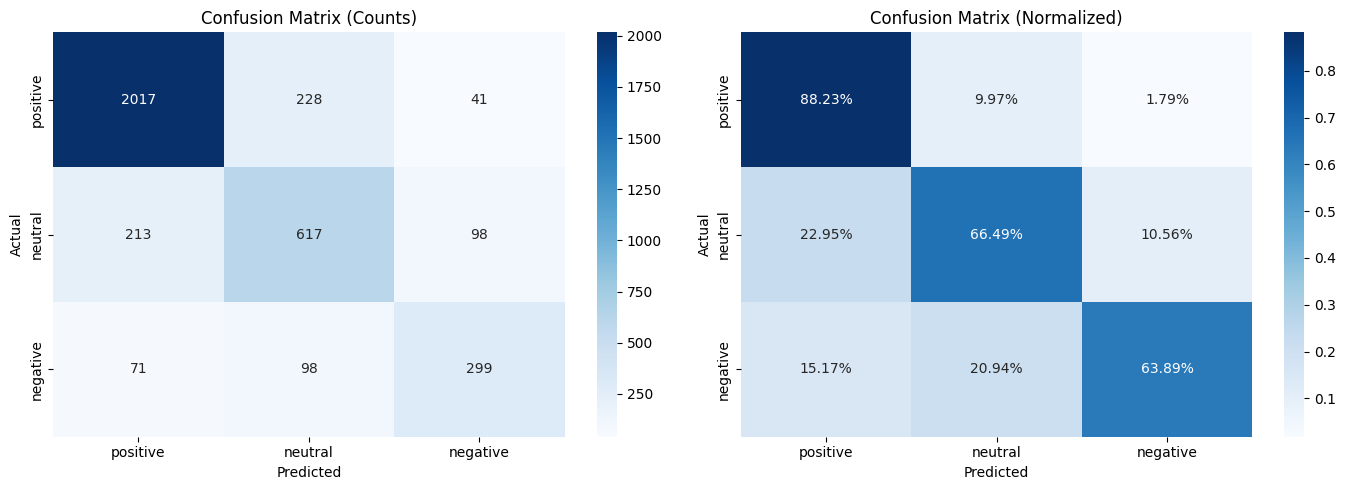

In [5]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized (percentage)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

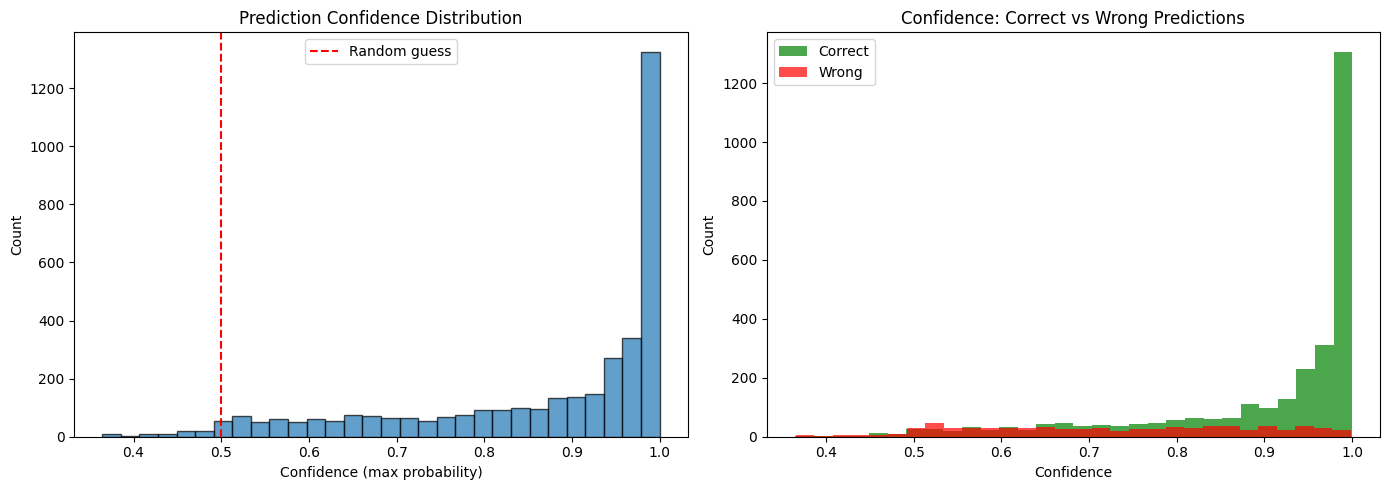

Mean confidence (correct): 0.904
Mean confidence (wrong):   0.724


In [6]:
## Confidence distribution — how sure is the model about its predictions?
y_proba = svm_model.predict_proba(X_test_scaled)
y_confidence = y_proba.max(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confidence histogram
axes[0].hist(y_confidence, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Prediction Confidence Distribution')
axes[0].set_xlabel('Confidence (max probability)')
axes[0].set_ylabel('Count')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Random guess')
axes[0].legend()

# Confidence by correct vs wrong
correct_mask = y_pred == y_test
axes[1].hist(y_confidence[correct_mask], bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(y_confidence[~correct_mask], bins=30, alpha=0.7, label='Wrong', color='red')
axes[1].set_title('Confidence: Correct vs Wrong Predictions')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Mean confidence (correct): {y_confidence[correct_mask].mean():.3f}')
print(f'Mean confidence (wrong):   {y_confidence[~correct_mask].mean():.3f}')

PCA explained variance: 6.6% of total
Running t-SNE for visualization...


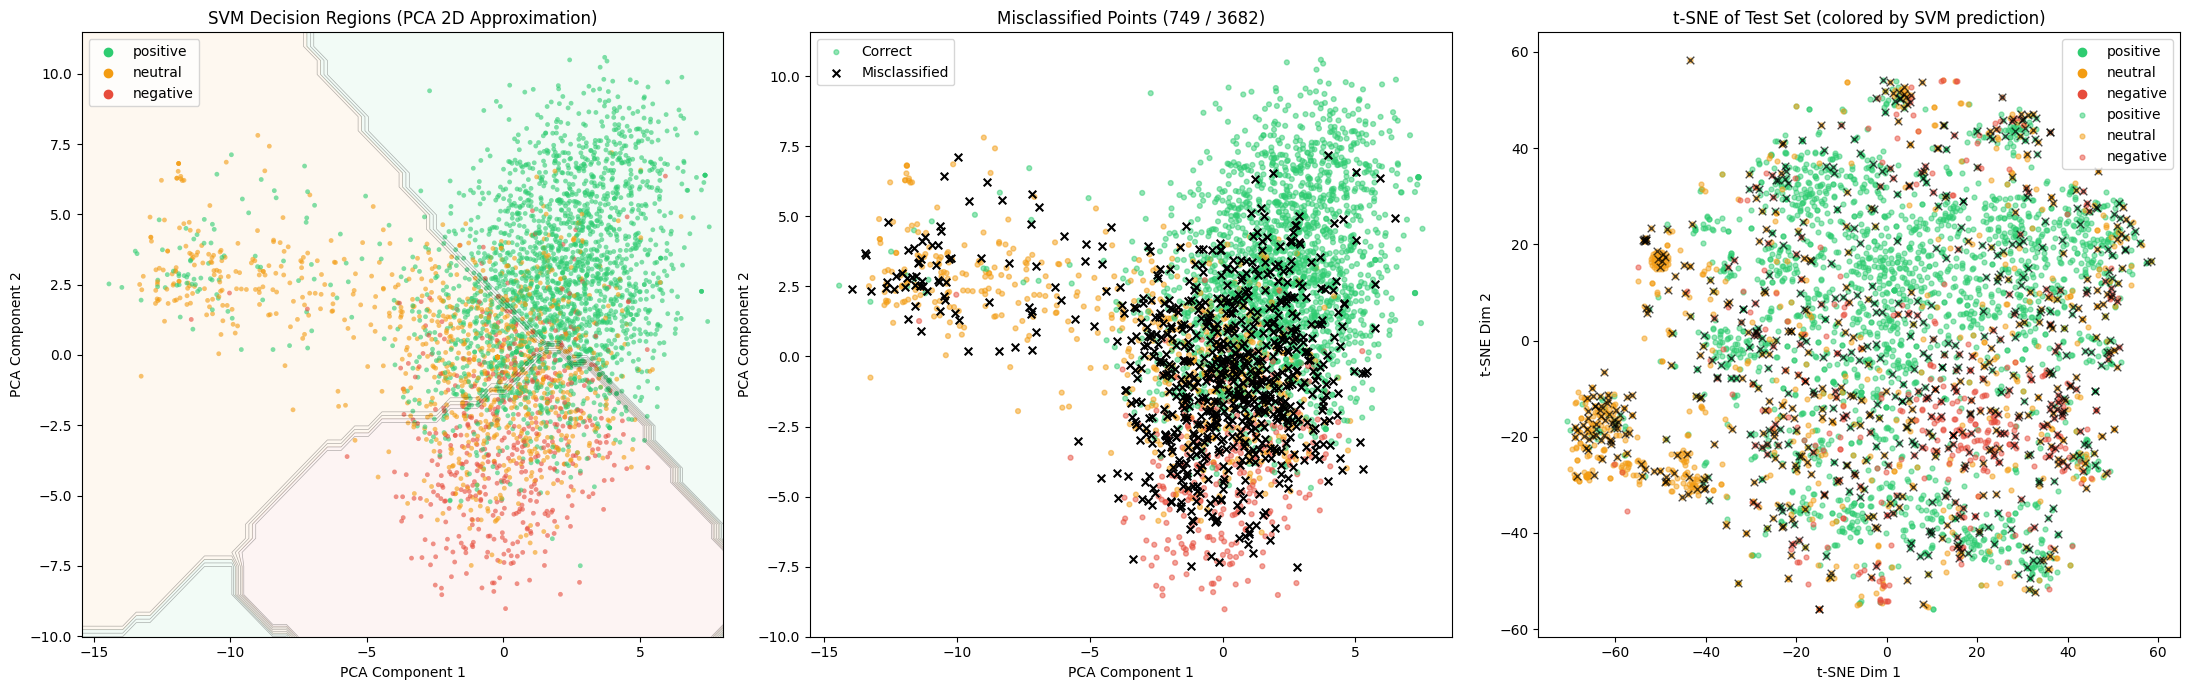


Misclassified: 749 / 3682 (20.3%)
Black × marks = wrong predictions


In [7]:
## Visualize SVM Classification in 2D
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# --- 1. PCA to 2D (preserves global structure better than t-SNE for decision boundaries) ---
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.1%} of total")

# --- 2. Train a lightweight SVM on the 2D projection (for decision boundary mesh) ---
from sklearn.svm import SVC as SVC2D
svm_2d = SVC2D(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_2d.fit(X_train_2d, y_train)

# --- 3. Create mesh grid for decision boundary ---
h = 0.5  # mesh step size
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# --- 4. Plot: Decision regions + test points ---
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

class_colors = ['#2ecc71', '#f39c12', '#e74c3c']  # positive, neutral, negative
cmap_bg = ListedColormap(['#d5f5e3', '#fdebd0', '#fadbd8'])  # light versions
cmap_pts = ListedColormap(class_colors)

# PLOT 1: SVM Decision Boundaries (2D approximation)
axes[0].contourf(xx, yy, Z, alpha=0.3, cmap=cmap_bg, levels=[-.5, .5, 1.5, 2.5])
axes[0].contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.3)
scatter = axes[0].scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test,
                          cmap=cmap_pts, s=12, alpha=0.6, edgecolors='none')
axes[0].set_title('SVM Decision Regions (PCA 2D Approximation)', fontsize=12)
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
legend_labels = [plt.scatter([], [], color=c, label=l) for c, l in zip(class_colors, target_names)]
axes[0].legend(handles=legend_labels, fontsize=10)

# PLOT 2: Actual vs Predicted (highlight misclassifications)
correct_mask = y_pred == y_test
axes[1].scatter(X_test_2d[correct_mask, 0], X_test_2d[correct_mask, 1],
                c=y_pred[correct_mask], cmap=cmap_pts, s=12, alpha=0.5, label='Correct')
axes[1].scatter(X_test_2d[~correct_mask, 0], X_test_2d[~correct_mask, 1],
                c='black', s=30, marker='x', linewidths=1.5, label='Misclassified')
axes[1].set_title(f'Misclassified Points ({(~correct_mask).sum()} / {len(y_test)})', fontsize=12)
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')
axes[1].legend(fontsize=10)

# PLOT 3: t-SNE colored by predicted label (better local structure)
from sklearn.manifold import TSNE
print("Running t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_test_tsne = tsne.fit_transform(X_test_scaled)

for label_id in sorted(inv_label_map.keys()):
    mask = y_pred == label_id
    axes[2].scatter(X_test_tsne[mask, 0], X_test_tsne[mask, 1],
                    color=class_colors[label_id], label=inv_label_map[label_id],
                    alpha=0.5, s=12)
# Overlay misclassified
axes[2].scatter(X_test_tsne[~correct_mask, 0], X_test_tsne[~correct_mask, 1],
                c='black', s=30, marker='x', linewidths=1, alpha=0.7)
axes[2].set_title('t-SNE of Test Set (colored by SVM prediction)', fontsize=12)
axes[2].set_xlabel('t-SNE Dim 1')
axes[2].set_ylabel('t-SNE Dim 2')
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

misclass_rate = (~correct_mask).sum() / len(y_test) * 100
print(f"\nMisclassified: {(~correct_mask).sum()} / {len(y_test)} ({misclass_rate:.1f}%)")
print(f"Black × marks = wrong predictions")

In [8]:
## Save model + scaler for deployment
joblib.dump(svm_model, os.path.join(MODEL_PATH, 'svm_sentiment.joblib'))
joblib.dump(scaler, os.path.join(MODEL_PATH, 'svm_scaler.joblib'))

# Save model performance metadata
model_info = {
    'model': 'SVM (RBF kernel)',
    'accuracy': float(acc),
    'features': metadata['features'],
    'feature_dim': int(X_train.shape[1]),
    'train_samples': int(X_train.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'label_map': label_map
}
with open(os.path.join(MODEL_PATH, 'svm_model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print('Saved:')
print(f'  Model:  {MODEL_PATH}svm_sentiment.joblib')
print(f'  Scaler: {MODEL_PATH}svm_scaler.joblib')
print(f'  Info:   {MODEL_PATH}svm_model_info.json')

Saved:
  Model:  /home/ram/sentiment_mlops/models/svm_sentiment.joblib
  Scaler: /home/ram/sentiment_mlops/models/svm_scaler.joblib
  Info:   /home/ram/sentiment_mlops/models/svm_model_info.json


In [9]:
## Quick test — predict on sample comments
from sentence_transformers import SentenceTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Load tools
st_model = SentenceTransformer(metadata['embedding_model'])
analyzer = SentimentIntensityAnalyzer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def predict_sentiment(texts):
    """End-to-end: raw text -> prediction + confidence"""
    # Embeddings (on cleaned text)
    cleaned = [clean_text(t) for t in texts]
    embs = st_model.encode(cleaned)
    
    # VADER (on raw text)
    vader = []
    for t in texts:
        s = analyzer.polarity_scores(t)
        vader.append([s['compound'], s['pos'], s['neg'], s['neu']])
    vader = np.array(vader)
    
    # Combine & scale
    features = np.hstack([embs, vader])
    features_scaled = scaler.transform(features)
    
    # Predict
    preds = svm_model.predict(features_scaled)
    proba = svm_model.predict_proba(features_scaled)
    
    results = []
    for i, text in enumerate(texts):
        results.append({
            'text': text[:80],
            'prediction': inv_label_map[preds[i]],
            'confidence': f"{proba[i].max():.1%}"
        })
    return pd.DataFrame(results)

# Test with sample comments
test_comments = [
    "This video is absolutely amazing! Best tutorial ever!",
    "Terrible content, waste of my time.",
    "The video is 10 minutes long.",
    "I love how you explained the concept so clearly, subscribed!",
    "Boring and poorly made, dislike.",
    "Can someone tell me the timestamp for the second part?"
]

predict_sentiment(test_comments)

/home/ram/sentiment_mlops/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 317.37it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


,text,prediction,confidence
0,This video is absolutely amazing! Best tutoria...,positive,100.0%
1,"Terrible content, waste of my time.",negative,98.6%
2,The video is 10 minutes long.,positive,57.8%
3,I love how you explained the concept so clearl...,positive,99.1%
4,"Boring and poorly made, dislike.",negative,99.6%
5,Can someone tell me the timestamp for the seco...,neutral,90.5%


In [10]:
predict_sentiment("what is this vedio about ?")

,text,prediction,confidence
0,w,neutral,97.1%
1,h,neutral,98.8%
2,a,neutral,99.6%
3,t,neutral,92.7%
4,,neutral,88.4%
5,i,neutral,91.7%
6,s,neutral,76.7%
7,,neutral,88.4%
8,t,neutral,92.7%
9,h,neutral,98.8%
